In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import pandas as pd
from sklearn import metrics

# Define the neural network architecture
class ParallelNN(nn.Module):
    def __init__(self, input1_size, input2_size, hidden_size, num_classes):
        super(ParallelNN, self).__init__()

        # Define the first pipeline
        self.pipeline1 = nn.Sequential(
                nn.Linear(input1_size, 2048),
                nn.BatchNorm1d(2048),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(2048, 1024),
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(1024, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, hidden_size)
            )

        # Define the second pipeline
        self.pipeline2 = nn.Sequential(
                nn.Linear(input2_size, 2048),
                nn.BatchNorm1d(2048),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(2048, 1024),
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(1024, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, hidden_size)
            )

        # Define the final classification layer
        self.classification = nn.Sequential(
            nn.Linear(2 * hidden_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x1, x2):
        out1 = self.pipeline1(x1)
        out2 = self.pipeline2(x2)

        # Concatenate the outputs
        merged_out = torch.cat((out1, out2), dim=1)

        # Apply the final classification layer
        final_out = self.classification(merged_out)
        return final_out
    
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def should_stop(self, current_loss):
        if self.best_loss is None or current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
        
        return self.counter >= self.patience

early_stopping = EarlyStopping(patience=5, min_delta=0.001)


# Define the input sizes, hidden size, and number of classes
#input1_size = 10  # Change this to match the number of features in your first dataset
#input2_size = 8   # Change this to match the number of features in your second dataset
#hidden_size = 64
#num_classes = 3   # Change this to match the number of classes in your classification task

# Initialize the model
#model = ParallelNN(input1_size, input2_size, hidden_size, num_classes)

# Define your loss function and optimizer
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)


In [2]:
from sklearn.preprocessing import QuantileTransformer

# Load the data from a CSV file
csv_name = '../data/preprocessed_data.csv'
data = pd.read_csv(csv_name)

# The first column is irrelevant, the second column is the label
# Divide the remaining columns into two datasets
NMR_FIRST_FEATURE = 60
data1 = torch.tensor(data.iloc[:, 1:NMR_FIRST_FEATURE - 1].values, dtype=torch.float32)
data2 = torch.tensor(data.iloc[:, NMR_FIRST_FEATURE - 1:].values, dtype=torch.float32)
labels = torch.tensor(data.iloc[:, 0].values, dtype=torch.long)

# Normalize the data
scaler1 = QuantileTransformer()
scaler2 = QuantileTransformer()
data1 = torch.tensor(scaler1.fit_transform(data1), dtype=torch.float32)
data2 = torch.tensor(scaler2.fit_transform(data2), dtype=torch.float32)

binary = True
num_classes = 2 if binary else 3
if binary:
    labels[labels == 2] = 1

# Define model, loss function, and optimizer
model = ParallelNN(input1_size=data1.shape[1], input2_size=data2.shape[1], hidden_size=32, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Prepare data loaders
dataset = TensorDataset(data1, data2, labels)
train_set, val_set = torch.utils.data.random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])
sampler = torch.utils.data.RandomSampler(train_set, replacement=True, num_samples=1000)
train_loader = DataLoader(train_set, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_set, batch_size=12, shuffle=False)

# Training loop
def train(model, dataloader, criterion, optimizer, best_loss):
    pbar = tqdm(dataloader)
    correct = 0
    running_loss = 0
    

    for (data1, data2, labels) in pbar:
        model.train()

        data1, data2, labels = data1, data2, labels

        optimizer.zero_grad()
        outputs = model(data1, data2)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * data1.size(0)

        loss.backward()
        optimizer.step()

        # correct += (outputs.argmax(dim=1) == labels).float().sum()
        correct += (outputs.argmax(dim=1) == labels).float().sum()
        accuracy = correct / 1000 # Number of training samples
         
        pbar.set_description(f"Loss: {running_loss / 1000:.4f}, Accuracy: {accuracy:.4f}")

    # Validation loop
    val_loss = 0
    val_accuracy = 0
    model.eval()

    with torch.no_grad():
        for (data1_v, data2_v, labels_v) in val_loader:

            outputs = model(data1_v, data2_v)
            loss = criterion(outputs, labels_v)
            val_loss += loss.item()
            val_accuracy += (outputs.argmax(dim=1) == labels_v).float().sum()

    val_loss /= len(val_loader)
    val_accuracy /= len(val_set)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model_two_pipeline_AD.pth')

    # Save latest model
    torch.save(model.state_dict(), 'latest_model_two_pipeline_AD.pth')

    return val_loss, val_accuracy, running_loss / 1000, accuracy
        

/Users/franky/Downloads/445-env/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (402). n_quantiles is set to n_samples.
  warnings.warn(
/Users/franky/Downloads/445-env/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (402). n_quantiles is set to n_samples.
  warnings.warn(


Epoch 1/30


Loss: 0.6063, Accuracy: 0.6750: 100%|██████████| 32/32 [00:01<00:00, 26.99it/s]


Validation Loss: 0.6502, Validation Accuracy: 0.5926
Epoch 2/30


Loss: 0.4253, Accuracy: 0.8190: 100%|██████████| 32/32 [00:01<00:00, 28.62it/s]


Validation Loss: 0.6142, Validation Accuracy: 0.6790
Epoch 3/30


Loss: 0.2589, Accuracy: 0.9190: 100%|██████████| 32/32 [00:01<00:00, 30.71it/s]


Validation Loss: 0.6917, Validation Accuracy: 0.6667
Epoch 4/30


Loss: 0.1951, Accuracy: 0.9300: 100%|██████████| 32/32 [00:01<00:00, 28.78it/s]


Validation Loss: 0.7219, Validation Accuracy: 0.7037
Epoch 5/30


Loss: 0.1429, Accuracy: 0.9520: 100%|██████████| 32/32 [00:01<00:00, 30.03it/s]


Validation Loss: 1.1337, Validation Accuracy: 0.6296
Epoch 6/30


Loss: 0.1102, Accuracy: 0.9580: 100%|██████████| 32/32 [00:01<00:00, 30.39it/s]


Validation Loss: 0.9542, Validation Accuracy: 0.6296
Epoch 7/30


Loss: 0.1351, Accuracy: 0.9460: 100%|██████████| 32/32 [00:01<00:00, 29.19it/s]


Validation Loss: 0.8694, Validation Accuracy: 0.7160
Epoch 8/30


Loss: 0.0865, Accuracy: 0.9740: 100%|██████████| 32/32 [00:01<00:00, 26.34it/s]


Validation Loss: 0.9145, Validation Accuracy: 0.6543
Epoch 9/30


Loss: 0.0768, Accuracy: 0.9710: 100%|██████████| 32/32 [00:01<00:00, 30.00it/s]


Validation Loss: 1.0133, Validation Accuracy: 0.6173
Epoch 10/30


Loss: 0.0639, Accuracy: 0.9800: 100%|██████████| 32/32 [00:01<00:00, 27.71it/s]


Validation Loss: 0.9085, Validation Accuracy: 0.6667
Epoch 11/30


Loss: 0.0609, Accuracy: 0.9800: 100%|██████████| 32/32 [00:01<00:00, 28.58it/s]


Validation Loss: 0.9173, Validation Accuracy: 0.6543
Epoch 12/30


Loss: 0.0715, Accuracy: 0.9730: 100%|██████████| 32/32 [00:01<00:00, 30.10it/s]


Validation Loss: 0.9712, Validation Accuracy: 0.6914
Epoch 13/30


Loss: 0.0466, Accuracy: 0.9910: 100%|██████████| 32/32 [00:01<00:00, 27.98it/s]


Validation Loss: 0.9718, Validation Accuracy: 0.6543
Epoch 14/30


Loss: 0.0506, Accuracy: 0.9870: 100%|██████████| 32/32 [00:01<00:00, 30.35it/s]


Validation Loss: 0.9828, Validation Accuracy: 0.6790
Epoch 15/30


Loss: 0.0432, Accuracy: 0.9890: 100%|██████████| 32/32 [00:01<00:00, 27.78it/s]


Validation Loss: 0.9204, Validation Accuracy: 0.6667
Epoch 16/30


Loss: 0.0453, Accuracy: 0.9890: 100%|██████████| 32/32 [00:01<00:00, 24.37it/s]


Validation Loss: 1.0063, Validation Accuracy: 0.6420
Epoch 17/30


Loss: 0.0358, Accuracy: 0.9890: 100%|██████████| 32/32 [00:01<00:00, 22.69it/s]


Validation Loss: 1.0175, Validation Accuracy: 0.6914
Epoch 18/30


Loss: 0.0323, Accuracy: 0.9920: 100%|██████████| 32/32 [00:01<00:00, 22.04it/s]


Validation Loss: 0.9887, Validation Accuracy: 0.6543
Epoch 19/30


Loss: 0.0378, Accuracy: 0.9870: 100%|██████████| 32/32 [00:01<00:00, 28.49it/s]


Validation Loss: 0.9751, Validation Accuracy: 0.6914
Epoch 20/30


Loss: 0.0358, Accuracy: 0.9890: 100%|██████████| 32/32 [00:01<00:00, 25.39it/s]


Validation Loss: 1.0275, Validation Accuracy: 0.6543
Epoch 21/30


Loss: 0.0327, Accuracy: 0.9900: 100%|██████████| 32/32 [00:01<00:00, 25.52it/s]


Validation Loss: 0.9935, Validation Accuracy: 0.6543
Epoch 22/30


Loss: 0.0364, Accuracy: 0.9880: 100%|██████████| 32/32 [00:01<00:00, 25.87it/s]


Validation Loss: 0.9667, Validation Accuracy: 0.6790
Epoch 23/30


Loss: 0.0332, Accuracy: 0.9920: 100%|██████████| 32/32 [00:01<00:00, 25.60it/s]


Validation Loss: 1.0179, Validation Accuracy: 0.6543
Epoch 24/30


Loss: 0.0313, Accuracy: 0.9900: 100%|██████████| 32/32 [00:01<00:00, 23.00it/s]


Validation Loss: 1.0409, Validation Accuracy: 0.6543
Epoch 25/30


Loss: 0.0219, Accuracy: 0.9970: 100%|██████████| 32/32 [00:01<00:00, 28.03it/s]


Validation Loss: 1.0032, Validation Accuracy: 0.6790
Epoch 26/30


Loss: 0.0280, Accuracy: 0.9880: 100%|██████████| 32/32 [00:01<00:00, 28.80it/s]


Validation Loss: 1.0223, Validation Accuracy: 0.6914
Epoch 27/30


Loss: 0.0309, Accuracy: 0.9940: 100%|██████████| 32/32 [00:01<00:00, 24.05it/s]


Validation Loss: 1.0315, Validation Accuracy: 0.6667
Epoch 28/30


Loss: 0.0381, Accuracy: 0.9910: 100%|██████████| 32/32 [00:01<00:00, 24.29it/s]


Validation Loss: 1.0265, Validation Accuracy: 0.6790
Epoch 29/30


Loss: 0.0414, Accuracy: 0.9890: 100%|██████████| 32/32 [00:01<00:00, 29.49it/s]


Validation Loss: 1.1790, Validation Accuracy: 0.6420
Epoch 30/30


Loss: 0.0280, Accuracy: 0.9910: 100%|██████████| 32/32 [00:01<00:00, 24.30it/s]


Validation Loss: 0.9859, Validation Accuracy: 0.6667
Finished training
Best cutoff threshold:  0.44515038


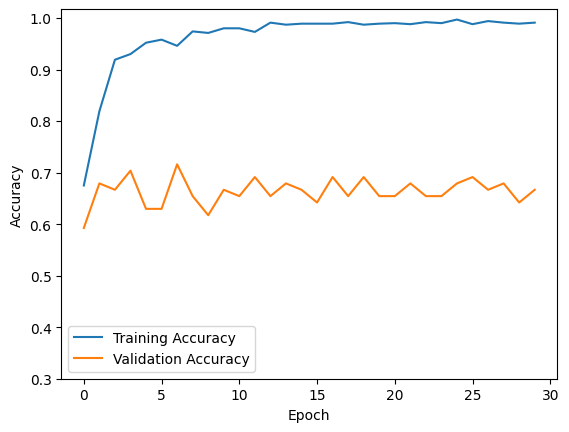

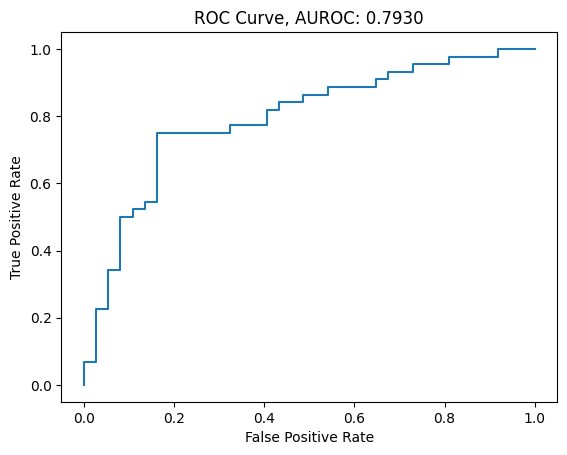

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, roc_auc_score
import numpy as np

# Main function
def main():
    num_epochs = 30

    accuracy_list = []
    loss_list = []
    val_accuracy_list = []
    val_loss_list = []

    best_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        val_loss, val_accuracy, loss, accuracy = train(model, train_loader, criterion, optimizer, best_loss)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        scheduler.step()

        accuracy_list.append(accuracy)
        loss_list.append(loss)
        val_accuracy_list.append(val_accuracy)
        val_loss_list.append(val_loss)

        best_loss = min(best_loss, val_loss)

    print("Finished training")

    binary_string = 'binary' if binary else 'multiclass'
    row_norm_string = 'quantile'

    # Plot the training and validation loss
    plt.figure()
    plt.plot(loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yticks([i/10 for i in range(0, 20, 2)])
    plt.legend()
    plt.savefig(f"../Results/loss_{binary_string}_{row_norm_string}_{num_epochs}_.png")

    plt.clf()
    plt.plot(accuracy_list, label='Training Accuracy')
    plt.plot(val_accuracy_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.yticks([i/10 for i in range(3, 11, 1)])
    plt.legend()
    plt.savefig(f"../Results/accuracy_{binary_string}_{row_norm_string}_{num_epochs}_.png")

    # Load the model (best or latest)
    model.load_state_dict(torch.load('best_model_two_pipeline_AD.pth'))

    model.eval()
    y_pred = []
    y_true = []
    y_pred_prob = pd.DataFrame()

    with torch.no_grad():
        for (data1, data2, labels) in val_loader:
            data1, data2, labels = data1, data2, labels

            outputs = model(data1, data2)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.argmax(dim=1).numpy())
            y_pred_prob = pd.concat([y_pred_prob, pd.DataFrame(outputs.softmax(dim=1))], ignore_index=True)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.savefig(f"../Results/confusion_matrix_{binary_string}_{row_norm_string}_{num_epochs}_.png")


    if binary:
        # Plot ROC curve with thresholds from 0.1 to 0.9
        plt.clf()
        # Calculate the AUROC score
        fpr, tpr, thresholds = roc_curve(pd.DataFrame(y_true), y_pred_prob[1])
        print("Best cutoff threshold: ", thresholds[np.argmax(tpr - fpr)])
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve, AUROC: {:.4f}'.format(roc_auc_score(pd.DataFrame(y_true), y_pred_prob[1])))
        plt.savefig(f"../Results/roc_curve_{binary_string}_{row_norm_string}_{num_epochs}_.png")


if __name__ == '__main__':
    main()